In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random
from collections import defaultdict

random.seed(42)

In [2]:
from models.allcnn2d import AllCNN2D
from drawing.interactive import draw_image

# Global

In [3]:
DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"

# Paths

In [4]:
file_path: str = os.path.abspath(".")
root_path: str = os.path.join(file_path, os.pardir, os.pardir)
checkpoint_path: str = os.path.join(
    root_path, 
    "checkpoints", 
    "GeckoFull_epoch1980_trainacc0.90605_valacc0.98089_Tloss0.78068_Vloss0.20101_lr6.320194197753456e-11.pkl"
)


# Load Model

In [5]:
label_map: list[str] = ['(', ')', '+', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'λ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '×', '÷']

model: AllCNN2D = AllCNN2D(
    **{
        "conv_features": (1, 16, 32, 32, 32, 32),
        "fully_connected_features": (64, 44),
        "expected_input_size": (64, 64),
        "device": "cpu",
        "conv_dropout": 0.0,
        "verbose": True,
        "name_prefix": "GeckoFinal",
        #"checkpoint_path": checkpoint_path
    }

)

Layer (type:depth-idx)                   Output Shape              Param #
AllCNN2D                                 [1, 44]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 16, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 16, 64, 64]           160
│    │    └─Dropout2d: 3-2               [1, 16, 64, 64]           --
│    │    └─BatchNorm2d: 3-3             [1, 16, 64, 64]           32
│    │    └─LeakyReLU: 3-4               [1, 16, 64, 64]           --
│    │    └─Conv2d: 3-5                  [1, 16, 32, 32]           2,320
│    │    └─Dropout2d: 3-6               [1, 16, 32, 32]           --
│    │    └─BatchNorm2d: 3-7             [1, 16, 32, 32]           32
│    │    └─LeakyReLU: 3-8               [1, 16, 32, 32]           --
│    └─Sequential: 2-2                   [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-9                  [1, 32, 32, 32]           4,640
│    │  

26
k


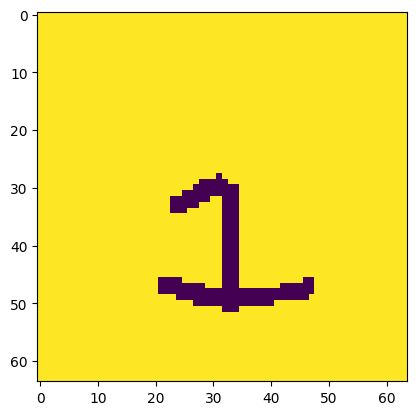

26
k


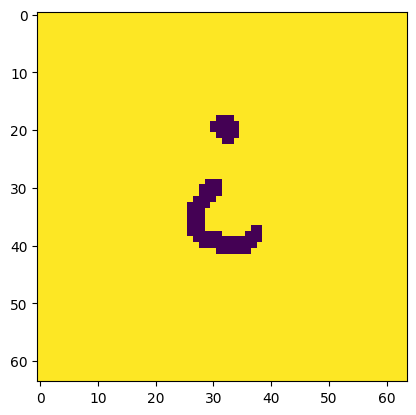

31
p


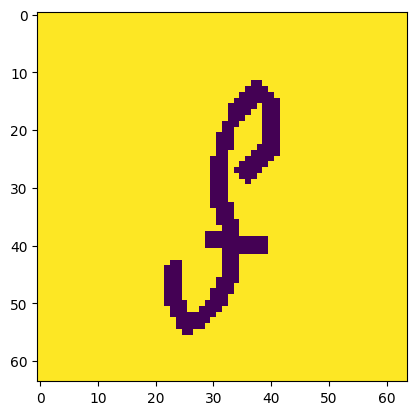

31
p


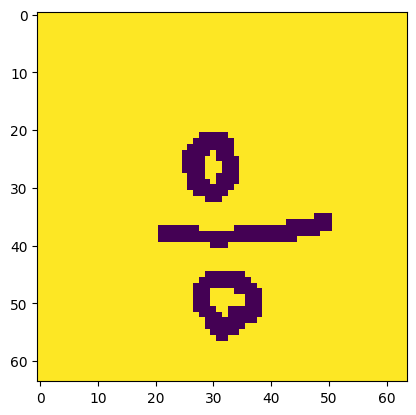

17
b


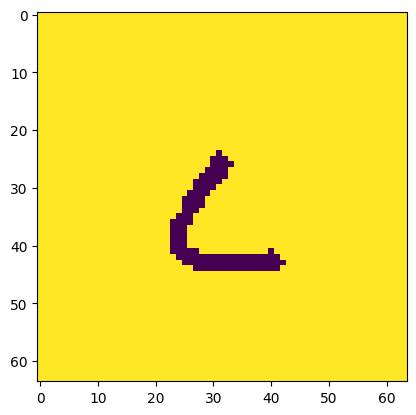

26
k


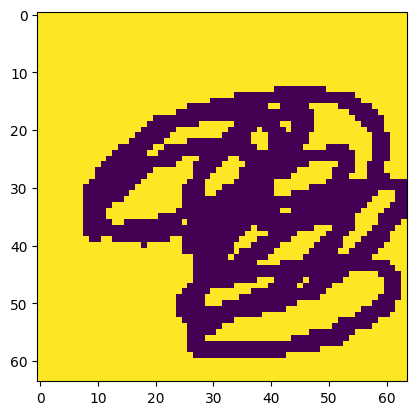

4
.


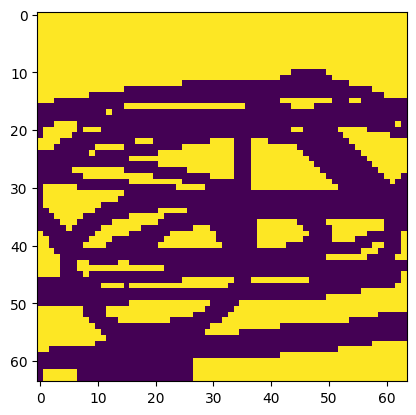

No image drawn.


In [6]:
stop_drawing = False

while not stop_drawing:

    # Example usage:
    drawn_image_np: np.ndarray | None = draw_image()
    
    
    if drawn_image_np is None:
        print("No image drawn.")
        stop_drawing = True
        continue
    
    drawn_image_np = drawn_image_np.astype(np.uint8).astype(np.float32)
    
    drawn_image_tensor: torch.Tensor = torch.tensor(
        drawn_image_np, 
        device=DEVICE
    )    
    drawn_image_tensor = drawn_image_tensor.unsqueeze(0)
    drawn_image_tensor = drawn_image_tensor.unsqueeze(0)
    
    logits: torch.Tensor = model.forward(drawn_image_tensor).detach().cpu()
    pred: int = torch.argmax(logits, dim=1).squeeze().item()
    
    print(pred)  # Should print (64, 64), a 64x64 numpy array
    print(label_map[pred])
    plt.imshow(drawn_image_np)
    plt.show()

        
        
    